In [1]:
!pip install tensorflow

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [3]:
import os
import pathlib

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # Check if the foldpath is a directory
        if not os.path.isdir(foldpath):
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # Check if there are nested directories
            if os.path.isdir(fpath):
                # Ignore 'masks' directories
                if os.path.basename(fpath).lower() == 'masks':
                    continue

                # Process files within nested directories
                for nested_file in os.listdir(fpath):
                    ipath = os.path.join(fpath, nested_file)
                    filepaths.append(ipath)
                    labels.append(fold)
            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    
    # Split into training and remaining (dummy) sets
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    
    # Further split the dummy set into validation and test sets
    strat_dummy = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_dummy)

    return train_df, valid_df, test_df

In [16]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fits them into image data generator, 
    because model takes data from image data generator.
    Image data generator converts images into tensors.
    '''
    img_size = (299, 299)  # Ensure the image size matches InceptionV3 requirements
    channels = 3  # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

# 使用更新后的图像生成器
batch_size = 16
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 16931 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience  # Epochs without improvement before adjusting learning rate
        self.stop_patience = stop_patience  # Number of times to adjust lr without improvement before stopping training
        self.threshold = threshold  # Training accuracy threshold for lr adjustment based on validation loss
        self.factor = factor  # Factor to reduce learning rate
        self.batches = batches  # Number of training batches per epoch
        self.epochs = epochs  # Total number of epochs
        self.ask_epoch = ask_epoch  # Epoch at which to ask user for input
        self.ask_epoch_initial = ask_epoch  # Save initial value to restore if restarting training

        # Callback variables
        self.count = 0  # Counter for epochs without improvement
        self.stop_count = 0  # Counter for learning rate adjustments
        self.best_epoch = 1  # Epoch with the lowest loss
        self.highest_tracc = 0.0  # Highest training accuracy
        self.lowest_vloss = np.inf  # Lowest validation loss
        self.best_weights = None  # Best model weights
        self.initial_lr = None  # Initial learning rate
        self.initial_weights = None  # Initial model weights

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # Initial learning rate
        self.initial_weights = self.model.get_weights()  # Save initial weights
        print('Do you want the model to ask you to halt the training [y/n]?')
        ans = input('').strip().lower()
        self.ask_permission = 1 if ans in ['y', 'yes'] else 0

        header = '{:^8s}{:^10s}{:^9s}{:^9s}{:^9s}{:^9s}{:^9s}{:^10s}{:^10s}{:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(header)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours, remainder = divmod(tr_duration, 3600)
        minutes, seconds = divmod(remainder, 60)

        print(f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds')
        self.model.set_weights(self.best_weights)  # Set the model weights to the best weights

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        print(f'Processing batch {batch + 1} of {self.batches} - accuracy: {acc:.3f} - loss: {loss:.5f}', end='\r')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if epoch > 0 else 0.0

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.lowest_vloss = min(self.lowest_vloss, v_loss)
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    self.count = 0
                    self.stop_count += 1
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if epoch > 0 else 0.0

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    self.count = 0
                    self.stop_count += 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{epoch + 1:^3}/{self.epochs:^4} {loss:^9.3f} {acc * 100:^9.3f} {v_loss:^9.5f} {v_acc * 100:^9.3f} {lr:^9.5f} {monitor:^11} {pimprov:^10.2f} {duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            print(f'Training halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement')
            self.model.stop_training = True
        elif self.ask_epoch is not None and self.ask_permission:
            if epoch + 1 >= self.ask_epoch:
                print('Enter H to halt training or an integer for the number of epochs to run before asking again')
                ans = input('').strip().lower()
                if ans in ['h']:
                    print(f'Training halted at epoch {epoch + 1} due to user input')
                    self.model.stop_training = True
                else:
                    try:
                        self.ask_epoch += int(ans)
                        print(f'Training will continue until epoch {self.ask_epoch}')
                        header = '{:^8s}{:^10s}{:^9s}{:^9s}{:^9s}{:^9s}{:^9s}{:^10s}{:^10s}{:^8s}'.format(
                            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                        print(header)
                    except ValueError:
                        print('Invalid input, continuing training without user intervention')


In [7]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [9]:
data_dir = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)
    
    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print(f'Invalid Input: {e}')

Found 16931 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


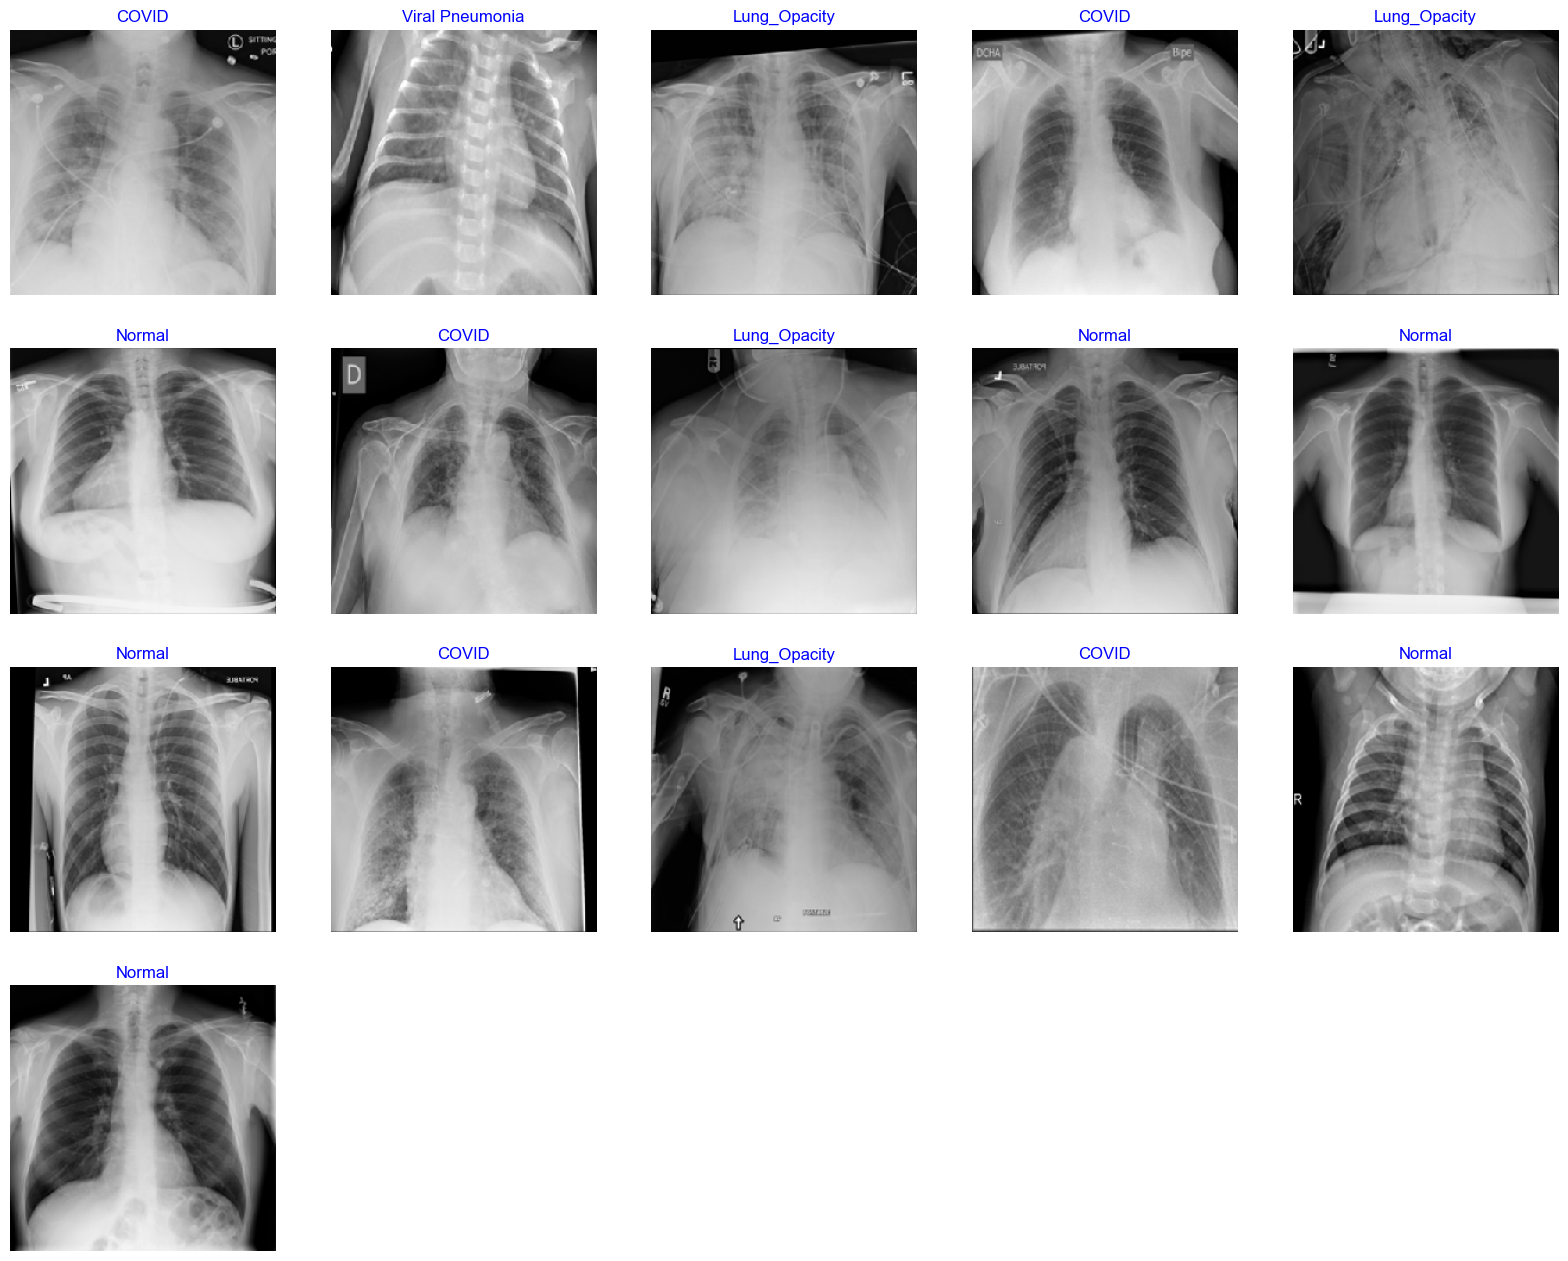

In [10]:
show_images(train_gen)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Ensure input shape
img_size = (299, 299)  # InceptionV3 requires 299x299 input size
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Create base model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Running the model once to ensure it is built
dummy_input = tf.zeros((1, *img_shape))  # Create a dummy input
model(dummy_input)  # Run model once with dummy input

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (1, 2048)              │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (1, 2048)              │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 256)               │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336,548 (85.21 MB)

 Trainable params: 22,298,020 (85.06 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [18]:
# Example usage
batch_size = 16
epochs = 20
patience = 3
stop_patience = 10
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want the model to ask you to halt the training [y/n]?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 20    5.567    47.463   37.85725   46.386    0.00100   accuracy      0.00    6837.90 
 2 / 20    2.118    48.101    1.80083   47.284    0.00100   accuracy      1.34    8923.02 
 3 / 20    1.341    48.137    1.24924   47.992    0.00100   accuracy      0.07    9203.79 
 4 / 20    1.211    48.154    1.19847   48.134    0.00100   accuracy      0.04    9446.47 
 5 / 20    1.159    48.154    1.16585   48.134    0.00100   accuracy      0.00    9652.50 
 6 / 20    1.125    48.154    1.11307   51.677    0.00100   accuracy      0.00    8773.50 
 7 / 20    1.108    49.985    1.05335   59.282    0.00100   accuracy      3.80    7033.72 
 8 / 20    1.058    60.156    0.87656   77.846    0.00100   accuracy     20.35    6996.88 
 9 / 20    0.917    73.168    0.70920   91.497    0.00100   accuracy     21.63    6870.65 
10 / 20    0.814    76.835    0.58846   92.631    0.00100   accuracy      5.01    6821.29

In [37]:
# 保存模型到文件
model.save('/Users/fangshiyuan/Desktop/UCL/毕设-1/InceptionV3.h5')

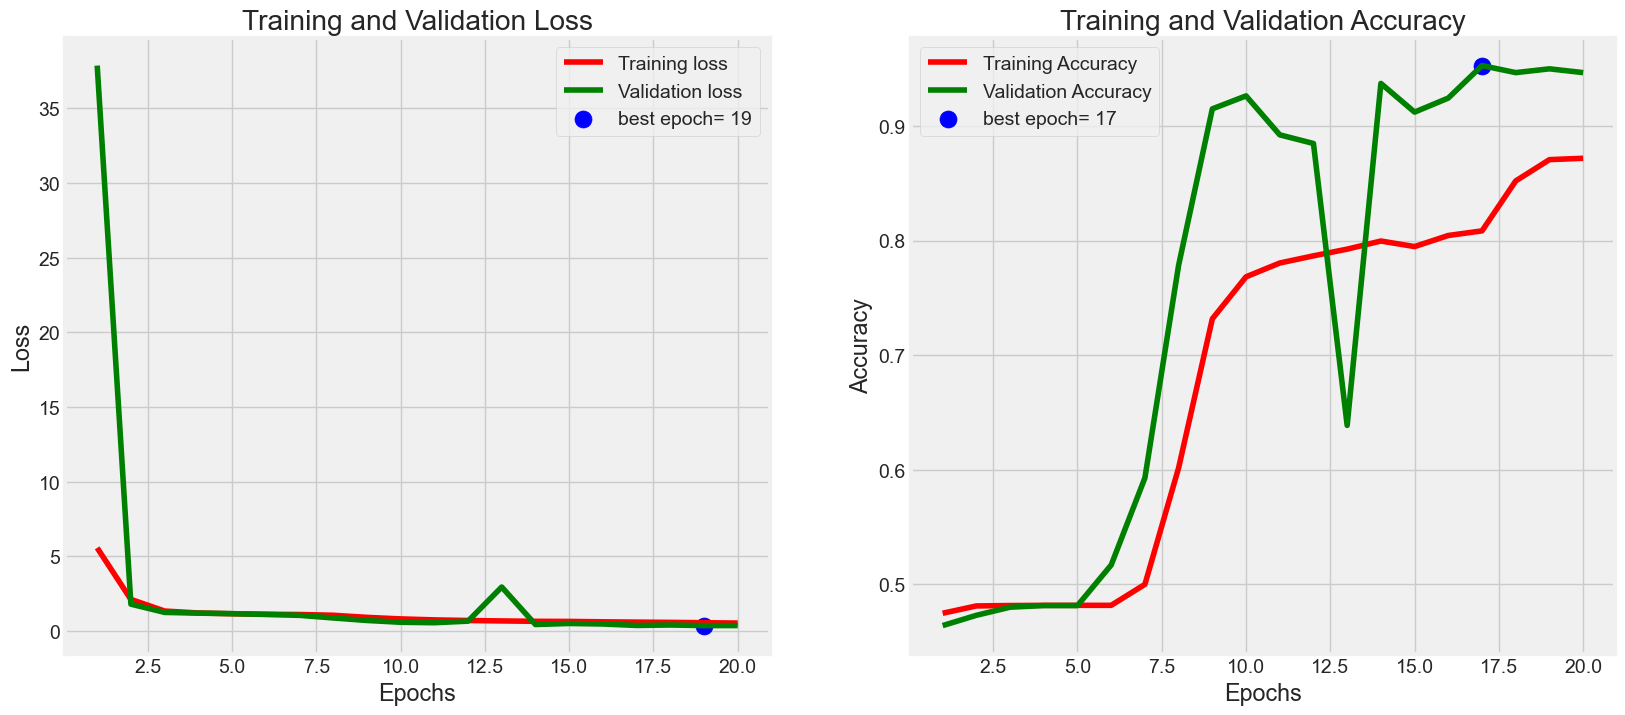

In [19]:
plot_training(history)

In [20]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.9519 - loss: 0.3531
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.9466 - loss: 0.3684
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9425 - loss: 0.7759
Train Loss:  0.3418293297290802
Train Accuracy:  0.9568965435028076
--------------------
Validation Loss:  0.3812223970890045
Validation Accuracy:  0.9375
--------------------
Test Loss:  0.7712136507034302
Test Accuracy:  0.9400094747543335


In [21]:
# 假设 test_gen 已经定义并准备好使用
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
[1 1 1 ... 2 2 2]


Confusion Matrix, Without Normalization
[[358   1   2   0]
 [  7 505  89   0]
 [  7  13 998   2]
 [  2   0   4 129]]
                 precision    recall  f1-score   support

          COVID       0.96      0.99      0.97       361
   Lung_Opacity       0.97      0.84      0.90       601
         Normal       0.91      0.98      0.94      1020
Viral Pneumonia       0.98      0.96      0.97       135

       accuracy                           0.94      2117
      macro avg       0.96      0.94      0.95      2117
   weighted avg       0.94      0.94      0.94      2117



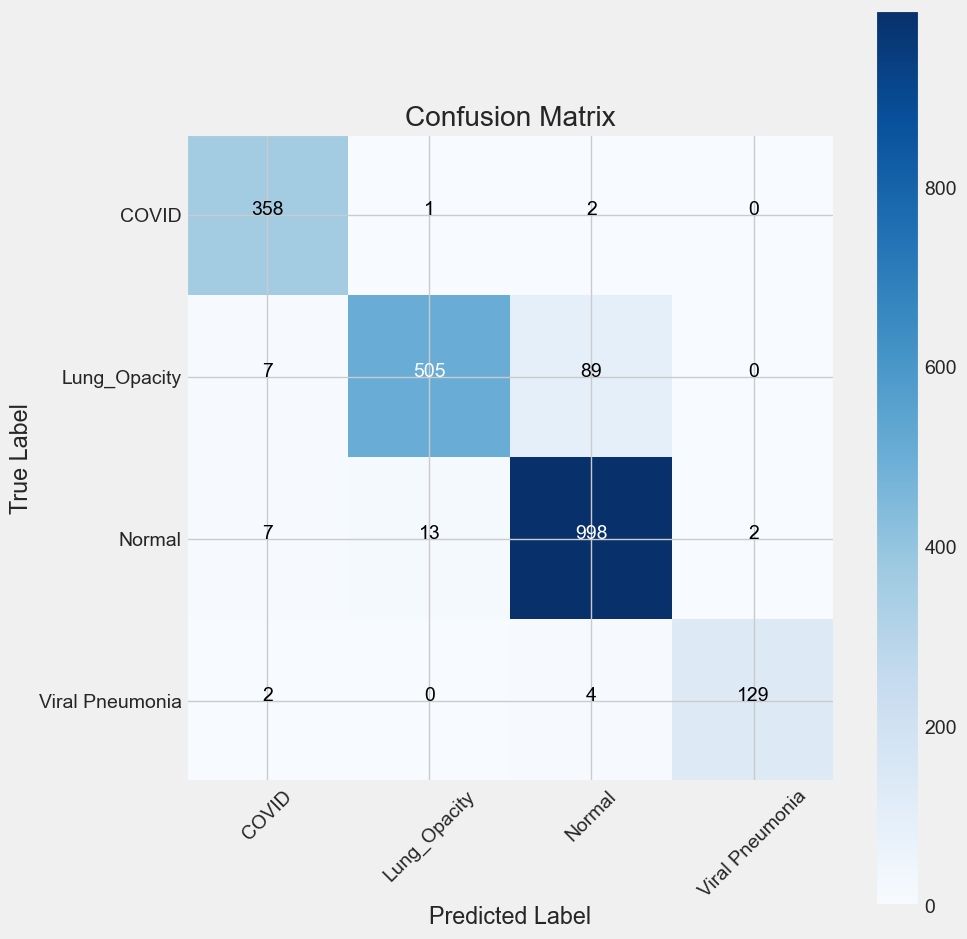

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [24]:
# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

# 打印模型层名称以确定最后一个卷积层的名称
for layer in model.layers:
    print(layer.name)

ValueError: Invalid dtype: tuple

In [21]:
# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

# 指定最后一个卷积层的名称（这里假设为 'top_conv'，你需要根据你的模型实际名称调整）
last_conv_layer_name = "top_conv"

# 准备图像
img_path = "/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png"  # 替换为你的图像路径
img_array = get_img_array(img_path, size=(224, 224))

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存和显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: Invalid dtype: tuple

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.inputs], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 示例使用
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
last_conv_layer_name = 'top_conv'  # 确保这是模型中的实际卷积层名称

img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path, heatmap)

NameError: name 'Model' is not defined

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.inputs], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用示例
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
last_conv_layer_name = 'top_conv'  # EfficientNetB0中的实际卷积层名称

img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path, heatmap)

NameError: name 'Model' is not defined

In [25]:
for layer in model.layers:
    print(layer.name)

efficientnetb0
batch_normalization
dense
dropout
dense_1


In [26]:
# 获取 EfficientNetB0 模型的内部层
efficientnetb0_model = model.get_layer('efficientnetb0')

# 打印 EfficientNetB0 模型的层名称以查找最后一个卷积层
for layer in efficientnetb0_model.layers:
    print(layer.name)

input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [32]:
def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.inputs], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [33]:
# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: Invalid dtype: tuple

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.input], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: Invalid dtype: tuple

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.input], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: Invalid dtype: tuple

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def get_img_array(img_path, size):
    """Load an image and convert it to an array."""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    grad_model = Model(
        inputs=[model.input], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Save and display Grad-CAM heatmap."""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: The layer sequential has never been called and thus has no defined input.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf

def get_img_array(img_path, size):
    """加载图像并将其转换为数组。"""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """生成 Grad-CAM 热图。"""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # 获取输入和输出
    grad_model = Model(
        inputs=[base_model.input], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """保存并显示 Grad-CAM 热图。"""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 显式调用模型以建立输入张量
dummy_input = tf.zeros((1, *img_shape))  # 创建一个虚拟输入
_ = model(dummy_input)  # 使用虚拟输入运行模型一次

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: The layer sequential has never been called and thus has no defined output.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf

# 加载保存的模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

def get_img_array(img_path, size):
    """加载图像并将其转换为数组。"""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = tf.convert_to_tensor(array, dtype=tf.float32)  # 确保数据类型为float32
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """生成 Grad-CAM 热图。"""
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # 获取输入和输出
    grad_model = Model(
        inputs=[base_model.input], 
        outputs=[last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """保存并显示 Grad-CAM 热图。"""
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 确定最后一个卷积层的名称
last_conv_layer_name = 'top_conv'  # 从之前的输出中确定

# 获取图像数组
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img_array = get_img_array(img_path, size=(224, 224))  # 假设图像大小为224x224

# 生成Grad-CAM热图
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 保存并显示Grad-CAM热图
save_and_display_gradcam(img_path, heatmap)

ValueError: Invalid dtype: tuple

In [44]:
model.save('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model1.h5', save_format='h5')

In [45]:
# 保存模型为 .h5 格式
model.save('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model2.h5')

# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model2.h5')

ValueError: Invalid dtype: tuple

In [46]:
# 加载模型
model = tf.keras.models.load_model('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

ValueError: Invalid dtype: tuple

In [47]:
for layer in model.layers:
    print(layer.name)

efficientnetb0
batch_normalization
dense
dropout
dense_1


In [48]:
# 获取 EfficientNetB0 模型的内部层
efficientnetb0_model = model.get_layer('efficientnetb0')

# 打印 EfficientNetB0 模型的层名称以查找最后一个卷积层
for layer in efficientnetb0_model.layers:
    print(layer.name)

input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [50]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 计算 Grad-CAM 热力图
last_conv_layer_name = 'top_conv'  # EfficientNetB0 的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

ValueError: No such layer: top_conv. Existing layers are: ['efficientnetb0', 'batch_normalization', 'dense', 'dropout', 'dense_1'].

In [52]:
# 找到基础模型的层名称
for layer in model.layers:
    print(layer.name)

# EfficientNetB0 的子层
for layer in model.get_layer('efficientnetb0').layers:
    print(layer.name)

efficientnetb0
batch_normalization
dense
dropout
dense_1
input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squee

In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'top_conv'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

ValueError: No such layer: top_conv. Existing layers are: ['efficientnetb0', 'batch_normalization', 'dense', 'dropout', 'dense_1'].

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

In [55]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取 EfficientNetB0 子模型
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [56]:
last_conv_layer_name = 'top_conv'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

ValueError: The layer sequential has never been called and thus has no defined output.

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取 EfficientNetB0 子模型
    base_model = model.get_layer('efficientnetb0')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 确保模型被初始化并调用
dummy_input = tf.zeros((1, 224, 224, 3))
model(dummy_input)

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'top_conv'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

ValueError: The layer sequential has never been called and thus has no defined output.

In [61]:
# 打印模型架构
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 1280)              │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 1280)              │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,061,801 (49.83 MB)

 Trainable params: 4,339,072 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,678,146 (33.10 MB)

In [62]:
# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 224, 224, 3))
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

tf.Tensor([[0.4110407  0.08927571 0.25216928 0.24751431]], shape=(1, 4), dtype=float32)


In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 224, 224, 3))
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取 EfficientNetB0 子模型
    base_model = model.get_layer('efficientnetb0')
    print(f"EfficientNetB0 model layers: {[layer.name for layer in base_model.layers]}")  # 打印 EfficientNetB0 模型的层

    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 确保模型被初始化并调用
dummy_input = tf.zeros((1, 224, 224, 3))
model(dummy_input)

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'top_conv'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 1280)              │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 1280)              │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,061,801 (49.83 MB)

 Trainable params: 4,339,072 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,678,146 (33.10 MB)

tf.Tensor([[0.4110407  0.08927571 0.25216928 0.24751431]], shape=(1, 4), dtype=float32)
EfficientNetB0 model layers: ['input_layer', 'rescaling', 'normalization', 'rescaling_1', 'stem_conv_pad', 'stem_conv', 'stem_bn', 'stem_activation', 'block1a_dwconv', 'block1a_bn', 'block1a_activation', 'block1a_se_squeeze', 'block1a_se_reshape', 'block1a_se_reduce', 'block1a_se_expand', 'block1a_se_excite', 'block1a_project_conv', 'block1a_project_bn', 'block2a_expand_conv', 'block2a_expand_bn', 'block2a_expand_activation', 'block2a_dwconv_pad', 'block2a_dwconv', 'block2a_bn', 'block2a_activation', 'block2a_se_squeeze', 'block2a_se_reshape', 'block2a_se_reduce', 'block2a_se_expand', 'block2a_se_excite', 'block2a_project_conv', 'block2a_project_bn', 'block2b_expand_conv', 'block2b_expand_bn', 'block2b_expand_activation', 'block2b_dwconv', 'block2b_bn', 'block2b_activation', 'block2b_se_squeeze', 'block2b_se_reshape', 'block2b_se_reduce', 'block2b_se_expand', 'block2b_se_excite', 'block2b_project_co

ValueError: The layer sequential has never been called and thus has no defined output.

Image data analysis using Grad-CAM

Config - Parameters

In [64]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "top_conv"

# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis

img_path = ["/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png"]

In [65]:
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [66]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


ValueError: No such layer: top_conv. Existing layers are: ['input_layer_2', 'block1_conv1', 'block1_conv1_bn', 'block1_conv1_act', 'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act', 'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act', 'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d', 'block2_pool', 'batch_normalization_1', 'add', 'block3_sepconv1_act', 'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act', 'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_1', 'block3_pool', 'batch_normalization_2', 'add_1', 'block4_sepconv1_act', 'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act', 'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_2', 'block4_pool', 'batch_normalization_3', 'add_2', 'block5_sepconv1_act', 'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act', 'block5_sepconv2', 'block5_sepconv2_bn', 'block5_sepconv3_act', 'block5_sepconv3', 'block5_sepconv3_bn', 'add_3', 'block6_sepconv1_act', 'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act', 'block6_sepconv2', 'block6_sepconv2_bn', 'block6_sepconv3_act', 'block6_sepconv3', 'block6_sepconv3_bn', 'add_4', 'block7_sepconv1_act', 'block7_sepconv1', 'block7_sepconv1_bn', 'block7_sepconv2_act', 'block7_sepconv2', 'block7_sepconv2_bn', 'block7_sepconv3_act', 'block7_sepconv3', 'block7_sepconv3_bn', 'add_5', 'block8_sepconv1_act', 'block8_sepconv1', 'block8_sepconv1_bn', 'block8_sepconv2_act', 'block8_sepconv2', 'block8_sepconv2_bn', 'block8_sepconv3_act', 'block8_sepconv3', 'block8_sepconv3_bn', 'add_6', 'block9_sepconv1_act', 'block9_sepconv1', 'block9_sepconv1_bn', 'block9_sepconv2_act', 'block9_sepconv2', 'block9_sepconv2_bn', 'block9_sepconv3_act', 'block9_sepconv3', 'block9_sepconv3_bn', 'add_7', 'block10_sepconv1_act', 'block10_sepconv1', 'block10_sepconv1_bn', 'block10_sepconv2_act', 'block10_sepconv2', 'block10_sepconv2_bn', 'block10_sepconv3_act', 'block10_sepconv3', 'block10_sepconv3_bn', 'add_8', 'block11_sepconv1_act', 'block11_sepconv1', 'block11_sepconv1_bn', 'block11_sepconv2_act', 'block11_sepconv2', 'block11_sepconv2_bn', 'block11_sepconv3_act', 'block11_sepconv3', 'block11_sepconv3_bn', 'add_9', 'block12_sepconv1_act', 'block12_sepconv1', 'block12_sepconv1_bn', 'block12_sepconv2_act', 'block12_sepconv2', 'block12_sepconv2_bn', 'block12_sepconv3_act', 'block12_sepconv3', 'block12_sepconv3_bn', 'add_10', 'block13_sepconv1_act', 'block13_sepconv1', 'block13_sepconv1_bn', 'block13_sepconv2_act', 'block13_sepconv2', 'block13_sepconv2_bn', 'conv2d_3', 'block13_pool', 'batch_normalization_4', 'add_11', 'block14_sepconv1', 'block14_sepconv1_bn', 'block14_sepconv1_act', 'block14_sepconv2', 'block14_sepconv2_bn', 'block14_sepconv2_act', 'avg_pool', 'predictions'].

In [24]:
for layer in model.layers:
    print(layer.name)

inception_v3
batch_normalization_284
dense_4
dropout_2
dense_5


In [28]:
# 列出 InceptionV3 子模型中的所有层
for layer in model.get_layer('inception_v3').layers:
    print(layer.name)

input_layer_4
conv2d_188
batch_normalization_190
activation_188
conv2d_189
batch_normalization_191
activation_189
conv2d_190
batch_normalization_192
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_193
activation_191
conv2d_192
batch_normalization_194
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_198
activation_196
conv2d_194
conv2d_197
batch_normalization_196
batch_normalization_199
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_195
batch_normalization_197
batch_normalization_200
batch_normalization_201
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_205
activation_203
conv2d_201
conv2d_204
batch_normalization_203
batch_normalization_206
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_202
batch_normalization_204
batch_normalization_207
batch_normalization_208
activation_200


In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)  # 使用适合 InceptionV3 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    base_model = model.get_layer('inception_v3')
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'mixed10'  # 使用 InceptionV3 模型的最后一个卷积层
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Last conv layer output: <KerasTensor shape=(None, 5, 5, 2048), dtype=float32, sparse=False, name=keras_tensor_4706>


ValueError: The layer sequential_7 has never been called and thus has no defined input.

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (1, 2048)              │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (1, 2048)              │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 256)               │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,932,590 (255.33 MB)

 Trainable params: 22,298,020 (85.06 MB)

 Non-trainable params: 38,528 (150.50 KB)

 Optimizer params: 44,596,042 (170.12 MB)

tf.Tensor([[0.90400493 0.02511145 0.04703705 0.02384649]], shape=(1, 4), dtype=float32)


ValueError: No such layer: block14_sepconv2_act. Existing layers are: ['inception_v3', 'batch_normalization_284', 'dense_4', 'dropout_2', 'dense_5'].

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

tf.Tensor(
[[-7.01367259e-01 -2.71231562e-01 -7.37264097e-01 -6.15619600e-01
  -4.71668839e-01 -2.04040468e-01 -1.41711462e+00 -4.06628072e-01
  -1.29895663e+00 -3.91931325e-01 -1.86093569e-01 -5.98330855e-01
  -6.05435431e-01 -2.52146691e-01 -1.03774905e+00 -5.28618932e-01
   2.06172004e-01 -1.09463787e+00 -4.84543562e-01 -5.47791898e-01
  -8.76489878e-01  1.61443341e+00  1.01121306e+00  3.75434637e-01
  -1.76962748e-01 -1.62851602e-01 -1.59252316e-01 -2.09516257e-01
   2.38012120e-01 -6.03555560e-01 -1.12646270e+00  4.68249172e-02
  -4.76630002e-01 -1.10446262e+00 -4.46020365e-01 -8.82462740e-01
  -8.92271757e-01 -1.09001684e+00  1.30812645e+00 -1.04589415e+00
  -4.13833141e-01 -5.43128014e-01  1.36515722e-01 -2.08674192e-01
  -3.19398612e-01 -4.46846902e-01 -3.20722967e-01  4.04222280e-01
  -1.16724586e+00 -1.10422659e+00 -5.59472322e-01  5.03352702e-01
   3.63822341e-01 -2.86572278e-02 -6.60669923e-01 -1.59274131e-01
  -6.41475320e-01 -1.01409674e+00 -1.51290774e+00  1.21117389e+00

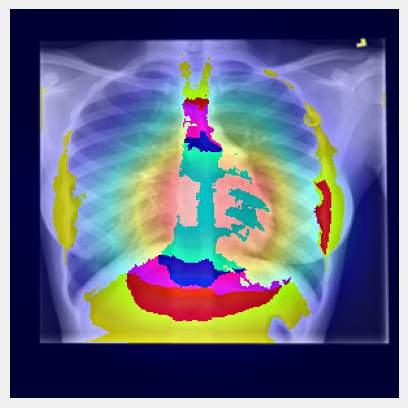

In [72]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

tf.Tensor(
[[-7.01367259e-01 -2.71231562e-01 -7.37264097e-01 -6.15619600e-01
  -4.71668839e-01 -2.04040468e-01 -1.41711462e+00 -4.06628072e-01
  -1.29895663e+00 -3.91931325e-01 -1.86093569e-01 -5.98330855e-01
  -6.05435431e-01 -2.52146691e-01 -1.03774905e+00 -5.28618932e-01
   2.06172004e-01 -1.09463787e+00 -4.84543562e-01 -5.47791898e-01
  -8.76489878e-01  1.61443341e+00  1.01121306e+00  3.75434637e-01
  -1.76962748e-01 -1.62851602e-01 -1.59252316e-01 -2.09516257e-01
   2.38012120e-01 -6.03555560e-01 -1.12646270e+00  4.68249172e-02
  -4.76630002e-01 -1.10446262e+00 -4.46020365e-01 -8.82462740e-01
  -8.92271757e-01 -1.09001684e+00  1.30812645e+00 -1.04589415e+00
  -4.13833141e-01 -5.43128014e-01  1.36515722e-01 -2.08674192e-01
  -3.19398612e-01 -4.46846902e-01 -3.20722967e-01  4.04222280e-01
  -1.16724586e+00 -1.10422659e+00 -5.59472322e-01  5.03352702e-01
   3.63822341e-01 -2.86572278e-02 -6.60669923e-01 -1.59274131e-01
  -6.41475320e-01 -1.01409674e+00 -1.51290774e+00  1.21117389e+00

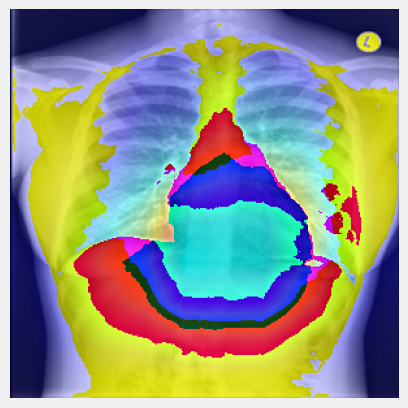

In [73]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

tf.Tensor(
[[-7.01367259e-01 -2.71231562e-01 -7.37264097e-01 -6.15619600e-01
  -4.71668839e-01 -2.04040468e-01 -1.41711462e+00 -4.06628072e-01
  -1.29895663e+00 -3.91931325e-01 -1.86093569e-01 -5.98330855e-01
  -6.05435431e-01 -2.52146691e-01 -1.03774905e+00 -5.28618932e-01
   2.06172004e-01 -1.09463787e+00 -4.84543562e-01 -5.47791898e-01
  -8.76489878e-01  1.61443341e+00  1.01121306e+00  3.75434637e-01
  -1.76962748e-01 -1.62851602e-01 -1.59252316e-01 -2.09516257e-01
   2.38012120e-01 -6.03555560e-01 -1.12646270e+00  4.68249172e-02
  -4.76630002e-01 -1.10446262e+00 -4.46020365e-01 -8.82462740e-01
  -8.92271757e-01 -1.09001684e+00  1.30812645e+00 -1.04589415e+00
  -4.13833141e-01 -5.43128014e-01  1.36515722e-01 -2.08674192e-01
  -3.19398612e-01 -4.46846902e-01 -3.20722967e-01  4.04222280e-01
  -1.16724586e+00 -1.10422659e+00 -5.59472322e-01  5.03352702e-01
   3.63822341e-01 -2.86572278e-02 -6.60669923e-01 -1.59274131e-01
  -6.41475320e-01 -1.01409674e+00 -1.51290774e+00  1.21117389e+00

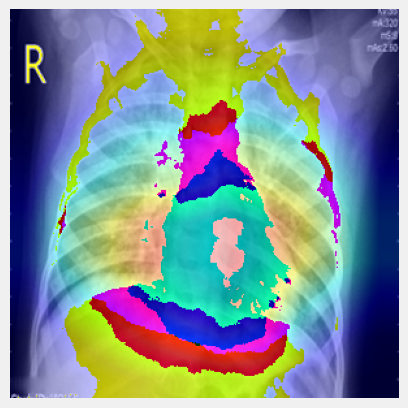

In [76]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

tf.Tensor(
[[-7.01367259e-01 -2.71231562e-01 -7.37264097e-01 -6.15619600e-01
  -4.71668839e-01 -2.04040468e-01 -1.41711462e+00 -4.06628072e-01
  -1.29895663e+00 -3.91931325e-01 -1.86093569e-01 -5.98330855e-01
  -6.05435431e-01 -2.52146691e-01 -1.03774905e+00 -5.28618932e-01
   2.06172004e-01 -1.09463787e+00 -4.84543562e-01 -5.47791898e-01
  -8.76489878e-01  1.61443341e+00  1.01121306e+00  3.75434637e-01
  -1.76962748e-01 -1.62851602e-01 -1.59252316e-01 -2.09516257e-01
   2.38012120e-01 -6.03555560e-01 -1.12646270e+00  4.68249172e-02
  -4.76630002e-01 -1.10446262e+00 -4.46020365e-01 -8.82462740e-01
  -8.92271757e-01 -1.09001684e+00  1.30812645e+00 -1.04589415e+00
  -4.13833141e-01 -5.43128014e-01  1.36515722e-01 -2.08674192e-01
  -3.19398612e-01 -4.46846902e-01 -3.20722967e-01  4.04222280e-01
  -1.16724586e+00 -1.10422659e+00 -5.59472322e-01  5.03352702e-01
   3.63822341e-01 -2.86572278e-02 -6.60669923e-01 -1.59274131e-01
  -6.41475320e-01 -1.01409674e+00 -1.51290774e+00  1.21117389e+00

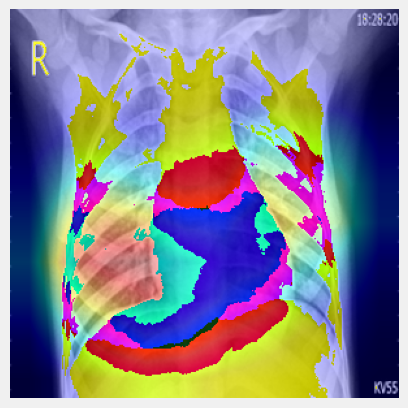

In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)